# Setup and Data Loading
Start by importing necessary libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Set seed for reproducibility
np.random.seed(1234)

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_id     10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   job_title        7342 non-null   object 
 6   state            8030 non-null   object 
 7   party            10238 non-null  object 
 8   barely_true_c    10238 non-null  float64
 9   false_c          10238 non-null  float64
 10  half_true_c      10238 non-null  float64
 11  mostly_true_c    10238 non-null  float64
 12  pants_on_fire_c  10238 non-null  float64
 13  context          10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


clean the data and check for missing values

In [3]:
# show me the NA number for each column
train_data.isnull().sum()


statement_id          0
label                 0
statement             0
subject               2
speaker               2
job_title          2898
state              2210
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
context             102
dtype: int64

In [4]:
# take off the 2 rows that cintain in all the columns NA
# show me the row with the NA in the spkear column
train_data[train_data.speaker.isnull()]
# drop the row with the NA in the spkear column and reset the index
train_data.dropna(subset=['speaker'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data.isnull().sum()

statement_id          0
label                 0
statement             0
subject               0
speaker               0
job_title          2896
state              2208
party                 0
barely_true_c         0
false_c               0
half_true_c           0
mostly_true_c         0
pants_on_fire_c       0
context             100
dtype: int64

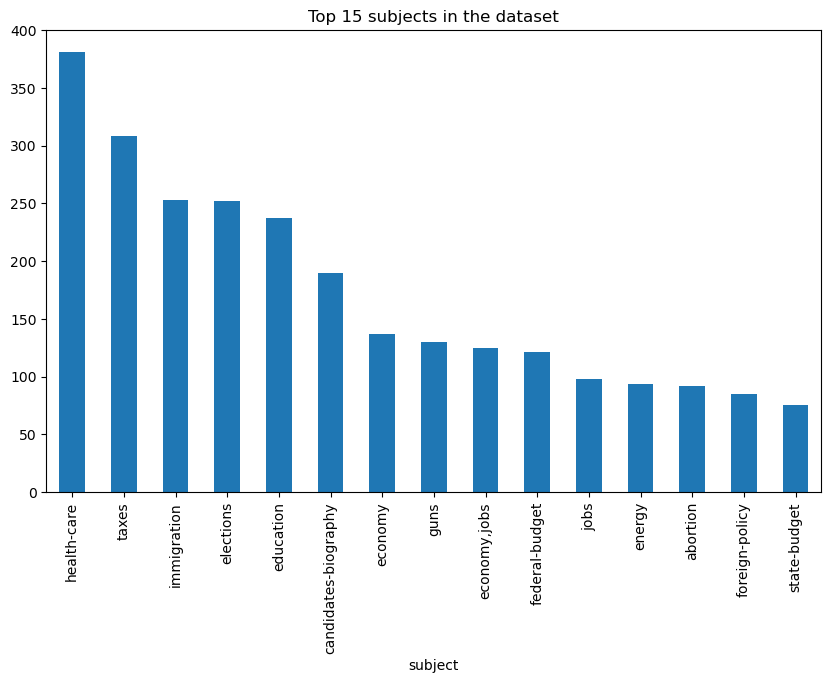

In [5]:
# show the distrubution of the the subject column show the top 15

train_data['subject'].value_counts().head(15).plot(kind='bar', figsize=(10, 6), title='Top 15 subjects in the dataset')
plt.show()

In [6]:
# print the rows with NA values
train_data[train_data['job_title'].isnull()]

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
13,8616.json,mostly-true,The economy bled $24 billion due to the govern...,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,0.0,0.0,2.0,4.0,0.0,a Doonesbury strip in the Sunday comics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,1592.json,half-true,"Under the ruling of the Supreme Court, any lob...","corporations,elections",david-axelrod,NaN,NaN,democrat,2.0,1.0,6.0,7.0,0.0,an interview on ABC's This Week
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate


In [7]:
# for thw rows with NA values in the job_title column, print the unique values of the context column
train_data[train_data['job_title'].isnull()]['context'].unique()





: 